# Training ADHunter on TREBL-seq data
GOAL: Transfer learn to predict $t_{1/2}$ from TREBL-seq using transfer learning from my Gcn4 model. This is similar to `250324_trebl_model_t_half.ipynb` but I'm going to demonstrate different train/test split models more cleanly here. 

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
from Bio.Seq import Seq

pl.seed_everything(0)

Global seed set to 0


0

In [2]:
df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
# print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
df_ad = df[df["Activity"]=="active"].copy()

seqs = df_ad["AAseq"].to_numpy()
# activity = df["Vmax"].to_numpy()
# y_bin = (df_ad["Activity"] == "active").values


t_half = df_ad["T1/2"].to_numpy().reshape(-1, 1)
t_scaler = preprocessing.StandardScaler().fit(t_half)
t_half_scaled = t_scaler.transform(t_half)
y_cont = t_half_scaled
# Split t1/2 into above/below median
t_half_median = np.median(t_half)
y_bin = t_half > t_half_median
# Add speed annotations to df_ad
df_ad["speed"] = "fast"
df_ad.loc[y_bin.flatten(), "speed"] = "slow"


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

## Model 0: Train test split based on $t_{1/2}$ value
TODO: Add split fxn with random state arg

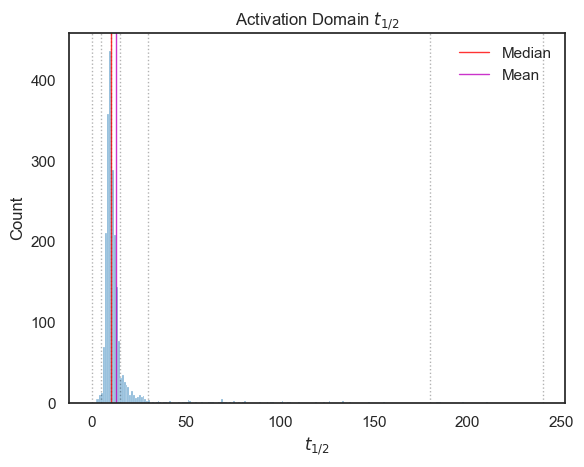

In [3]:
sns.histplot(t_half, discrete=True, legend=False)
for t in df.columns[4:11].astype(int):
    plt.axvline(t, linewidth=1, c='k', alpha=0.3, linestyle="dotted")
# plt.yscale("log")
plt.axvline(t_half_median, c='r', linewidth=1, alpha=0.8, label="Median")
plt.axvline(np.mean(t_half), c='m', linewidth=1, alpha=0.8, label="Mean")
plt.xlabel("$t_{1/2}$")
plt.title("Activation Domain $t_{1/2}$")
plt.legend(frameon=False, loc="upper right")
plt.show()

In [4]:
train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test

I SHOULD PROB WRAP THIS IN ONE FXN

In [5]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)
# Load pretrained model
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [6]:
# Train the model
dirpath="../misc/models"
csv_logger = CSVLogger('../misc/logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 21.32it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 25.44it/s]val_rmse 1.9252488613128662
val_pearsonr -0.1572374701499939
val_spearmanr -0.4634172320365906


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 38.88it/s, loss=0.875, v_num=43]val_rmse 1.1799120903015137
val_pearsonr 0.0962299332022667
val_spearmanr 0.3546082079410553
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 82.20it/s, loss=0.782, v_num=43]val_rmse 1.0615028142929077
val_pearsonr 0.1533983051776886
val_spearmanr 0.2877035140991211
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 84.74it/s, loss=0.686, v_num=43]val_rmse 1.0603104829788208
val_pearsonr 0.17981265485286713
val_spearmanr 0.2939777970314026
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 83.88it/s, loss=0.526, v_num=43]val_rmse 1.1283625364303589
val_pearsonr 0.017562536522746086
val_spearmanr 0.14062178134918213
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 90.60it/s, loss=0.463, v_num=43]val_rmse 1.1132009029388428
val_pearsonr 0.08707670867443085
val_spearmanr 0.24740728735923767
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 89.03it/s, loss=0.398, v_num=43]val_rmse 1.0607807636260986
val_pearsonr 0.18482908606529236


In [7]:
# Load the best model
ckpt_dict = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(ckpt_dict["state_dict"])

<All keys matched successfully>

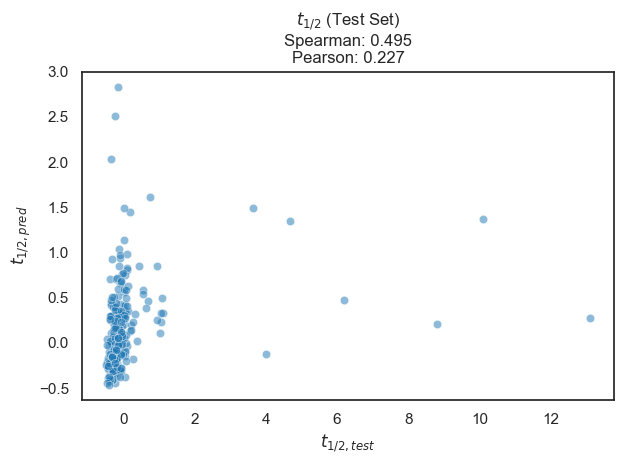

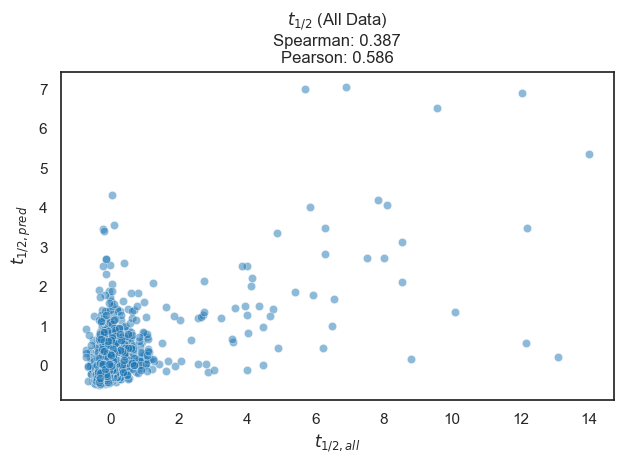

In [8]:
sns.set_style("white")
sns.set_context("notebook")

y_pred = model(X_test).detach().numpy().flatten()
y_te = y_cont_test.detach().numpy().flatten()


fig, ax = plt.subplots()
sns.scatterplot(x=y_te, y=y_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, test}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_te, y_pred).statistic.round(3)
pearson1 = pearsonr(y_te, y_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (Test Set)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

y_all_pred = model(torch.tensor(X)).detach().numpy().flatten()
y_all = y_cont.flatten()
fig, ax = plt.subplots()
sns.scatterplot(x=y_all, y=y_all_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, all}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_all, y_all_pred).statistic.round(3)
pearson1 = pearsonr(y_all, y_all_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (All Data)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

## Model 1: Train test split based on species


In [9]:
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
df_gcn4 = pd.read_csv(fn)
df_gcn4["Activity"] = df_gcn4["Activity"].fillna(0.0)
# df_gcn4 = df_gcn4.loc[df_gcn4.Activity != 0.0]
# df_gcn4 = df_gcn4.iloc[:, 1:]
df_gcn4 = df_gcn4.loc[df_gcn4.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# df_gcn4 = df_gcn4.dropna(subset=df_gcn4.columns[:-1], axis=0)
df_gcn4.rename(columns={"Seq": "AAseq"}, inplace=True)

In [10]:
# Append sequences only in trebl data to gcn4 dataframe and assign "None" as species name
trebl_unique = pd.DataFrame(df_ad["AAseq"][~df_ad["AAseq"].isin(df_gcn4["AAseq"])])
print(trebl_unique.shape)

(25, 1)


In [11]:
df_gcn4 = pd.concat([df_gcn4, trebl_unique], ignore_index=True)

In [12]:
# print(df.shape, df_gcn4.shape)
df_m = pd.merge(df_ad, df_gcn4, on="AAseq", suffixes=["_trebl", "_gcn4"]).sort_values(by="SpeciesNames")
df_m["SpeciesNames"] = df_m["SpeciesNames"].fillna("None")
df_m

,Unnamed: 0_trebl,level_0,index,Tile,0,5,10,15,30,180,...,Activity_trebl,T1/2,AAseq,speed,Unnamed: 0_gcn4,SpeciesNames,NativeLocation,NormLocation,Activity_gcn4,Stdev_BYS4_BioReps
463,463,NaN,NaN,ATGCCAACTAATGATTTAAATTCTGCTATTTCTATGTTTGAAATGA...,6.194464,9.135603,10.559775,11.368124,15.096697,11.628647,...,active,10.530747,MPTNDLNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHM,slow,87709.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,20.0,-115.0,54705.618558,85.565128
1802,1802,NaN,NaN,TCTACTGATTTGGATTCTGCTGTTGAGAACTTCTTTGGTTCTTCTT...,0.360111,4.120431,8.676081,11.721410,12.898664,13.449345,...,active,8.055872,STDLDSAVENFFGSSSDSTPLFEFEGLGKTTDPKTWSSLF,fast,87729.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,120.0,-15.0,262143.000000,NaN
1969,1969,NaN,NaN,TCTGATTCTACTCCATTGTTTGAATTTGAAGGTTTGGGTAAGACTA...,0.954741,4.561120,9.577172,14.694717,15.207149,17.645372,...,active,9.723771,SDSTPLFEFEGLGKTTDPKTWSSLFDDDIPVTLEDVSSVE,fast,87732.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,135.0,0.0,129540.750244,161829.257282
2015,2015,NaN,NaN,TCTGTTCCAATCTTCTCTGAATCTAAGAGATCTACTGATTTGGATT...,1.367910,3.876100,6.620588,10.923745,11.650322,10.364716,...,active,9.796916,SVPIFSESKRSTDLDSAVENFFGSSSDSTPLFEFEGLGKT,fast,87727.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,110.0,-25.0,150908.088872,NaN
276,276,NaN,NaN,ACTGATCCTAAGACTTGGTCTTCTTTGTTTGATGATGATATTCCAG...,0.597847,2.659881,4.457487,6.221736,8.724962,10.150257,...,active,12.597605,TDPKTWSSLFDDDIPVTLEDVSSVESITTAAGTESCFLPT,slow,87735.0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,150.0,15.0,153637.922819,73069.339945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,1799,NaN,NaN,TCTACTGATTCTACTCCAATGTTTGATTATGATAATTTGGAAGATA...,1.025557,4.170933,7.658006,10.881274,11.314568,15.254404,...,active,10.747649,STDSTPMFDYDNLEDNSKDWTSLFDNDIPVTTDDVSLADK,slow,NaN,None,NaN,NaN,NaN,NaN
1800,1800,NaN,NaN,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,2.679085,4.674611,5.114578,6.129602,7.458950,10.324391,...,active,24.677893,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,slow,NaN,None,NaN,NaN,NaN,NaN
1801,1801,NaN,NaN,TCTACTGATTCTATGCCAATGACTGAATATGAGAATTTGGAAGATA...,1.887299,20.817146,23.177571,33.684915,20.583454,23.656139,...,active,4.199402,STDSMPMTEYENLEDNLKEWTHLFDNVIPNTTDDVSLADK,fast,NaN,None,NaN,NaN,NaN,NaN
1812,1812,NaN,NaN,TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATT...,0.921482,3.854875,6.118787,8.659950,12.356368,12.586083,...,active,11.605048,STAPPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDG,slow,NaN,None,NaN,NaN,NaN,NaN


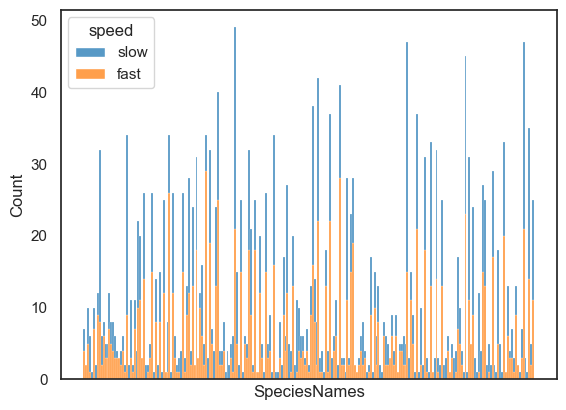

In [13]:
# sns.lineplot(df_m, x="NativeLocation", y="T1/2", hue="SpeciesNames")

# df_m.sort
sns.histplot(df_m, x="SpeciesNames", hue="speed", multiple="stack")
plt.xticks([])
plt.show()
# sns.scatterplot(pd.DataFrame(df_m.groupby(["SpeciesNames"])["T1/2"].std().dropna()).reset_index())
# sns.boxplot(df_m, y="T1/2", x="SpeciesNames")
# plt.show()

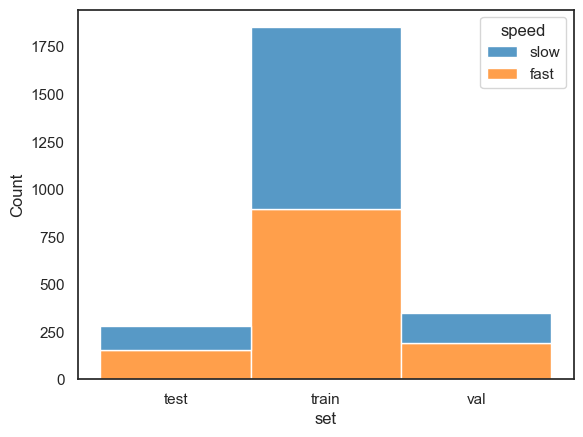

In [23]:
from sklearn.model_selection import GroupShuffleSplit

def get_group_split(X, y, groups, random_state=0, as_tensor=True):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=random_state)
    gss_val_test = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=random_state)
    tr_idx, te_val_index = [], []
    te_idx, val_idx = [], []

    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups=groups)):
        # Prepare the training and testing data
        X_train, X_test_val = X[train_index], X[test_index]
        y_train, y_test_val = y[train_index], y[test_index]
        # Keep track of indices
        tr_idx.append(train_index)
        te_val_index.append(test_index)

    te_val_index = np.array(te_val_index).flatten()

    groups_te_val = groups[te_val_index]
    for i, (test_index, val_index) in enumerate(gss_val_test.split(X_test_val, y_test_val, groups=groups_te_val)):
        X_test, X_val = X_test_val[test_index], X_test_val[val_index]
        y_test, y_val = y_test_val[test_index], y_test_val[val_index]
        te_idx.append(te_val_index[test_index])
        val_idx.append(te_val_index[val_index])


    tr_idx = np.array(tr_idx).flatten()
    te_idx = np.array(te_idx).flatten()
    val_idx = np.array(val_idx).flatten()
    if as_tensor:
        X_train = torch.tensor(X_train)
        # y_bin_train = torch.tensor(y_bin_train)
        y_train = torch.tensor(y_train)

        X_val = torch.tensor(X_val)
        # y_bin_val = torch.tensor(y_bin_val)
        y_val = torch.tensor(y_val)

        X_test = torch.tensor(X_test)
        # y_bin_test = torch.tensor(y_bin_test)
        y_test = torch.tensor(y_test)
    return (X_train, y_train), \
        (X_val, y_val), \
        (X_test, y_test), \
        (tr_idx, val_idx, te_idx)

train, val, test, indices = get_group_split(X, y_cont, df_m["SpeciesNames"].values, random_state=1)
(X_train, y_cont_train) = train
(X_val, y_cont_val) = val
(X_test, y_cont_test) = test
tr_idx, val_idx, te_index = indices
df_m.loc[df_m.iloc[tr_idx].index, ["set"]] = "train"
df_m.loc[df_m.iloc[te_index].index, ["set"]] = "test"
df_m.loc[df_m.iloc[val_idx].index, ["set"]] = "val"

sns.histplot(df_m, x="set", hue="speed", multiple="stack")
plt.show()

In [24]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [25]:
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [26]:
dirpath="../misc/models"
csv_logger = CSVLogger('../misc/logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 94.31it/s] val_rmse 1.8709063529968262
val_pearsonr -0.2606141269207001
val_spearmanr -0.5263848304748535
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 24.68it/s, loss=0.959, v_num=45]val_rmse 1.1704069375991821
val_pearsonr 0.18086355924606323
val_spearmanr 0.23150508105754852
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 89.88it/s, loss=0.826, v_num=45]val_rmse 0.9417247176170349
val_pearsonr 0.1349249929189682
val_spearmanr 0.3204938769340515
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 90.24it/s, loss=0.783, v_num=45]val_rmse 0.9480105638504028
val_pearsonr 0.12263309210538864
val_spearmanr 0.22413203120231628
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 89.11it/s, loss=0.494, v_num=45]val_rmse 0.9248145818710327
val_pearsonr 0.17781496047973633
val_spearmanr 0.24422363936901093
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 92.15it/s, loss=0.456, v_num=45]val_rmse 0.9421272277832031
val_pearsonr 0.18407070636749268
val_spearmanr 0.19126759469509125
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 70.54it/s, loss=0.35, v_num=45] val_rmse 0.9351434111595154
val_pearsonr 0.1456318646669387

In [27]:
# Load the best model
ckpt_dict = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(ckpt_dict["state_dict"])


<All keys matched successfully>

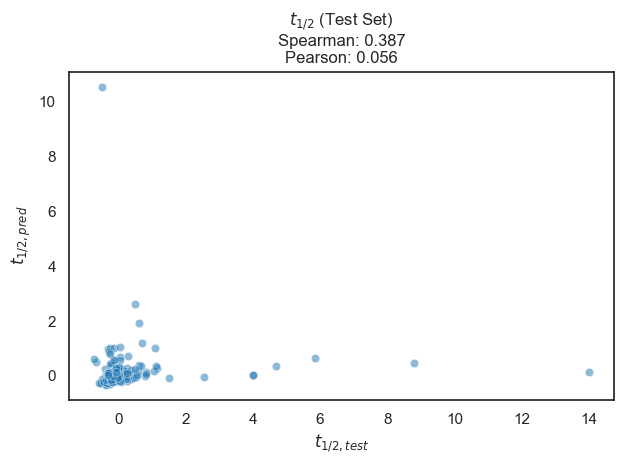

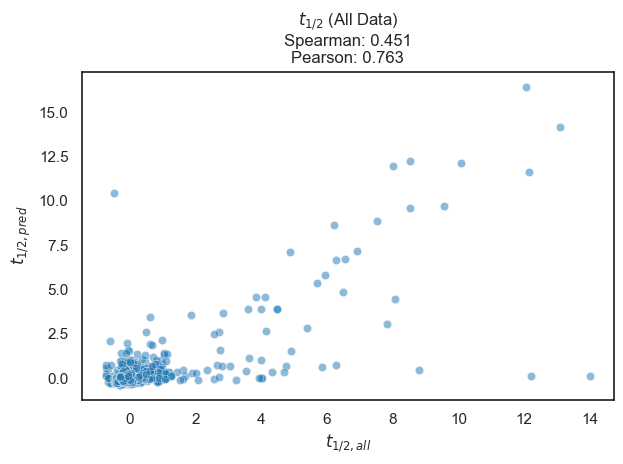

In [28]:
sns.set_style("white")
sns.set_context("notebook")

y_pred = model(X_test).detach().numpy().flatten()
y_te = y_cont_test.detach().numpy().flatten()


fig, ax = plt.subplots()
sns.scatterplot(x=y_te, y=y_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, test}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_te, y_pred).statistic.round(3)
pearson1 = pearsonr(y_te, y_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (Test Set)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

y_all_pred = model(torch.tensor(X)).detach().numpy().flatten()
y_all = y_cont.flatten()
fig, ax = plt.subplots()
sns.scatterplot(x=y_all, y=y_all_pred, alpha=.5, ax=ax)
ax.set_xlabel("$t_{1/2, all}$")
ax.set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_all, y_all_pred).statistic.round(3)
pearson1 = pearsonr(y_all, y_all_pred).statistic.round(3)
ax.set_title("$t_{1/2}$ (All Data)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()